# EECS 504 Homework 1
## Problem 3: Image Defogging

### Getting Started
Make your own copy of this notebook using **File -> Save a copy in Drive**, or if you have iPython installed locally, **File -> Download .ipynb** to do the exercises locally.

### Submitting
When you're ready to submit this problem, first run all of the code to ensure your outputs are included in the submission. Save the `.ipynb` file and submit it to Canvas as `HW1.3_<uniqname>.ipynb`, substituting your uniqname. Be sure your name, uniqname, and UMID are correct in the form fields below. If you want to preview how it will look when we grade it, we'll run a command similar to the one below:

`ipython nbconvert --to html HW1.3_<uniqname>.ipynb`


In [2]:
#@title Grading information { vertical-output: true }
Name = 'Yuan Cheng' #@param {type: 'string'}
Uniqname = 'yuacheng' #@param {type: 'string'}
UMID = '06358288' #@param {type: 'string'}

## Setup
Run the next two cells to import the modules you need and download the images

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import pickle

In [4]:
! wget -O city_im.jpg "https://drive.google.com/uc?export=download&id=1VpLcc3SxgZN2LZZfU8MizQLSQp8Fx0hO"
! wget -O city_haze_free.jpg "https://drive.google.com/uc?export=download&id=1vo41hV667RisXLVrgIC8yONhhml-665P"

--2021-03-13 17:31:20--  https://drive.google.com/uc?export=download&id=1VpLcc3SxgZN2LZZfU8MizQLSQp8Fx0hO
Resolving drive.google.com (drive.google.com)... 172.217.203.101, 172.217.203.139, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0p23cjpsqi47du14dh2lckhlejrugnt/1615656675000/16863313984454738797/*/1VpLcc3SxgZN2LZZfU8MizQLSQp8Fx0hO?e=download [following]
--2021-03-13 17:31:20--  https://doc-0c-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0p23cjpsqi47du14dh2lckhlejrugnt/1615656675000/16863313984454738797/*/1VpLcc3SxgZN2LZZfU8MizQLSQp8Fx0hO?e=download
Resolving doc-0c-as-docs.googleusercontent.com (doc-0c-as-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connecting to doc-0c-as-docs.googleusercontent.com (d

In [5]:
# utility function to plot the images
class utils:
  def imshow2(*ims):
    fig, ax = plt.subplots( 1, len(ims), figsize=(15,15))
    if len(ims) == 1:
      ax = [ax]
    for im,a in zip(ims,ax):
      a.set_axis_off()
      a.imshow(im, cmap='gray')

Visualize the hazy and haze free images

(667, 1000, 3)


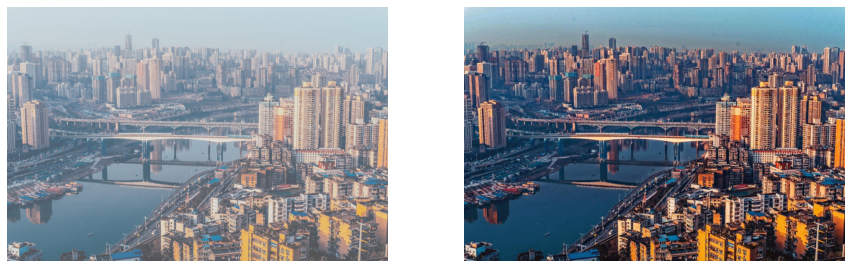

In [6]:
hazy_im1 = cv2.imread('city_im.jpg')
hazy_im1 = cv2.cvtColor(hazy_im1, cv2.COLOR_BGR2RGB)

haze_free_im1 = cv2.imread('city_haze_free.jpg')
haze_free_im1 = cv2.cvtColor(haze_free_im1, cv2.COLOR_BGR2RGB)

utils.imshow2(hazy_im1, haze_free_im1)
print(hazy_im1.shape)

## Image Defogging
In this homework, you would be implementing image defogging using dark channel prior as described in this classic paper

K. He, J. Sun and X. Tang, "Single Image Haze Removal Using Dark Channel Prior," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 33, no. 12, pp. 2341-2353, Dec. 2011, doi: 10.1109/TPAMI.2010.168.

We recommend that you read this paper, but it's not required as we have implemented the optimization algorithm for you.

First, we would require you to calculate dark channel in a given image.

In [7]:
def DarkChannel(im,sz):
  # your code here
  r,g,b = cv2.split(im)
  min_part1 = cv2.min(r,g)
  dc = cv2.min(min_part1, b)
  ##### end of your code
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
  dark = cv2.erode(dc,kernel)
  return dark

Next, you should validate, if dark channel prior is useful for haze removal. 

Implement a function to calculate histogram of dark channel. Then plot 2 histograms, one for the dark channel of hazy image and other for haze free image.

You can overlay the two histograms on the same figure. *np.histogram* is useful here, you can set *bins=64* and *sz=15*

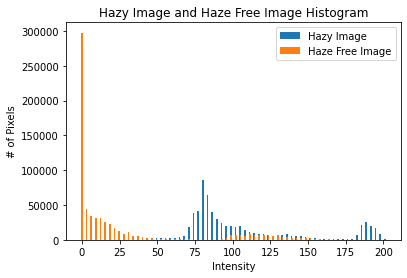

504834


In [28]:
## Your code here
dark_hazy = DarkChannel(hazy_im1, 15)
dark_haze_free = DarkChannel(haze_free_im1, 15)
histogram_hazy, bin_edges_hazy = np.histogram(dark_hazy, bins=64)
histogram_haze_free, bin_edges_haze_free = np.histogram(dark_haze_free, bins=64)
plt.figure()
plt.title("Hazy Image and Haze Free Image Histogram")
plt.xlabel("Intensity")
plt.ylabel("# of Pixels")

plt.bar(bin_edges_hazy[:-1],histogram_hazy,width=1)
plt.bar(bin_edges_haze_free[:-1], histogram_haze_free, width=1)
plt.legend(['Hazy Image','Haze Free Image'])
plt.show()
### end of your code
print(np.sum(histogram_haze_free[:8]))

If you implementation is correct, the output histogram for haze-free image would have ~75% pixels with intensity values less than 25 (calculate np.sum(hist_haze_free[:8])) and the histogram for hazy image shows peak at intensity different than 0.

## Haze Removal using Dark Channel Prior
The following functions implement the algorithm as outlined in the reference paper. We have completed these here for you.

In [ ]:
def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz=15):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
    return res

Given the functions above, implement the haze removal algorithm. You should follow these steps.


1.   Normalize the hazy image so that intensity values lie in range (0, 1)
2.   Calulate the dark channel of normalized hazy image, use sz = 15
3.   Calculate Atomspheric light using normalized image and dark channel
4.   Estimate the transmission using normalized image and Atmospheric light
5.   Refine the transmission using unnormalized hazy image
6.   Recover the haze free image



In [ ]:
# your code here
hazy_image_normalized = hazy_im1.astype('float64')/255
dark_channel = DarkChannel(hazy_image_normalized, 15)
Ato_light = AtmLight(hazy_image_normalized, dark_channel)
transmission = TransmissionEstimate(hazy_image_normalized, Ato_light)
transmission_refine = TransmissionRefine(hazy_im1, transmission)
recov_im1 = Recover(hazy_image_normalized, transmission_refine, Ato_light)
## end of your code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


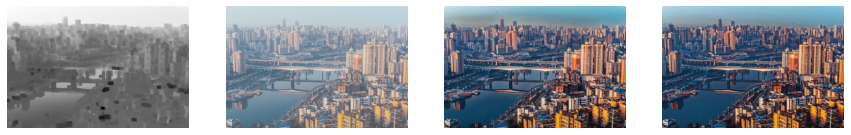

In [ ]:
utils.imshow2(dark_channel,hazy_im1,recov_im1,haze_free_im1)